# Handwriting Identification Experiment
__Date:__ _03-23-2020_

__Author:__ _Nathan Swedlund_


## Summary:
---
This project is simply an experiment to see if I can make a program that can Identify someone based on their handwriting. I started by asking some people I know to fill out a "survey". This only consisted of the survey takers writing the alphabet in capital letters four times each. You can find the "survey" in this repository. After every participant filled out the surveys, I scanned the document, and the rest is handled by this notebook.

### Handwriting digitization process
To get the images of the letters, I had some people I know fill out a letters document. After this, I scanned the document, and cropped the images to get each table.

---
## Setup
---
### Imports
importing libraries...

In [1]:
# For plotting images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# For the classifiers
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import tree

# For image manipulation
from PIL import Image

# For creating directories
import os

# For data storage
import numpy as np

---
## Separating Images
---

### Reading in Table Images

Response #1:


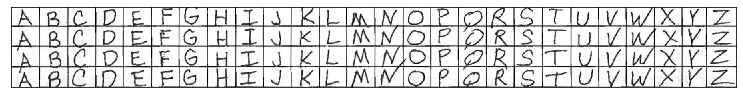

Response #2:


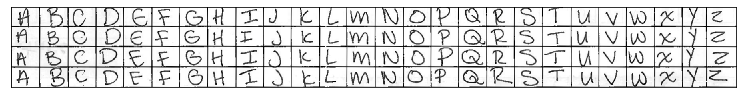

Response #3:


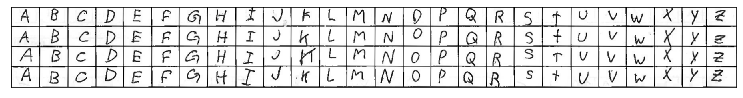

Response #4:


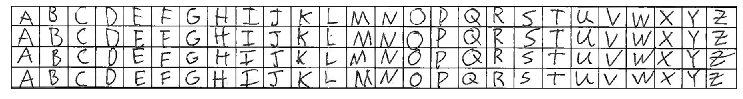

Response #5:


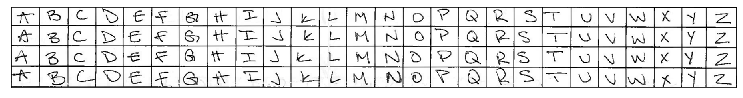

Response #6:


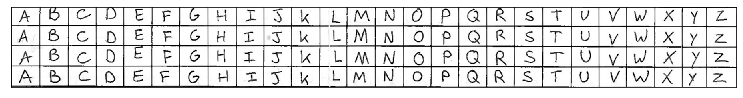

In [2]:
directory = "Responses"
prefix = "Table_"
postfix = ".png"
response_num = 6

# Reading in responses
tables = []
for i in range(1, response_num+1):
    image = directory+"/"+prefix+str(i)+postfix
    tables.append(Image.open(image))

# Plotting responses
for i, table in enumerate(tables):
    print(f"Response #{i+1}:")
    plt.figure(figsize=(26/2,4/2))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(table)
    plt.show()

### Resizing Tables

Response #1:


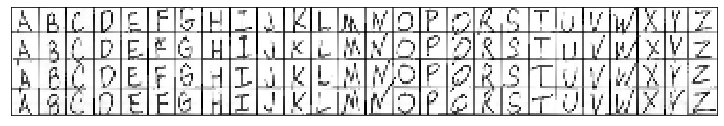

Response #2:


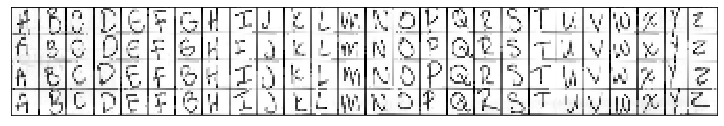

Response #3:


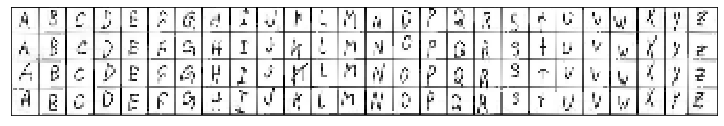

Response #4:


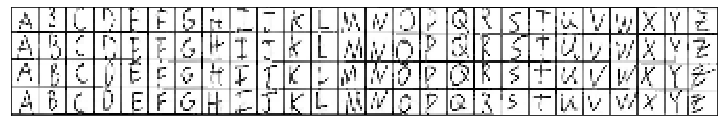

Response #5:


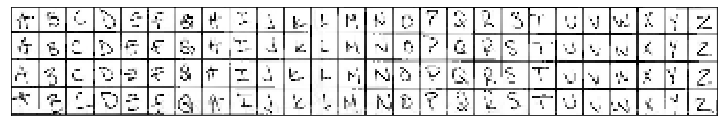

Response #6:


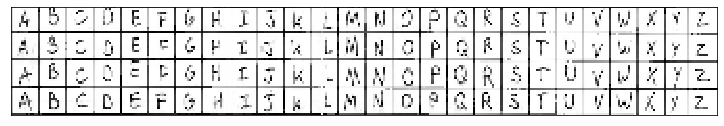

In [3]:
box_dim = 13 # Width/height of individual letter boxes

# Width/height of resized tables
width = box_dim*26
height = box_dim*4

# Making a copy of the tables and resizing
tables_resized = tables.copy() 
for i in range(len(tables)):
    tables_resized[i] = tables_resized[i].resize((width, height))

# Plotting resized images
for i, table in enumerate(tables_resized):
    print(f"Response #{i+1}:")
    plt.figure(figsize=(26/2,4/2))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(table)
    plt.show()

### Separating Tables into Individual Letters
Along with reading each letter individually, I will also white out the perimeter. If I didn't do this, the letter boxes would interfere with the classifier.

#### Storing Each Letter in `Letters`

In [4]:
letters = []
for table_num, table in enumerate(tables_resized):
    for row in range(4):
        for column in range(26):
            # Cropping image
            top_left = [ column*box_dim, row*box_dim]
            bottom_right = [top_left[0]+box_dim, top_left[1]+box_dim]
            coords = top_left+bottom_right
            
            cropped = np.array(table.crop(coords))
            
            # Whiting out the border
            cropped[0] = [ [255,255,255] for i in range(box_dim)]
            cropped[box_dim-1] = [ [255,255,255] for i in range(box_dim)]
            for i in range(box_dim):
                cropped[i][0] = [255, 255, 255]
                cropped[i][box_dim-1] = [255, 255, 255]

            # Appending the whited out, letter to the list
            letters.append(cropped)

### Removing Color From Pixels
To lower the amount of extraneous information, I will remove the color each letter. To keep the relative lightness the same, I will simply use the sum of the RGB values to represent each pixel. 

In [5]:
letters_bw = []
for i, letter in enumerate(letters):
    letters_bw.append([])
    for x, row in enumerate(letters[i]):
        letters_bw[i].append([])
        for j, pixel in enumerate(letters[i][x]):
            letters_bw[i][x].append(sum(letters[i][x][j]))

#### RGB Vs. Lightness comparison

In [6]:
print("Lightness representation of a pixel:", letters_bw[0][0][0])
print("RGB representation:", letter[0][0])

Lightness representation of a pixel: 765
RGB representation: [255 255 255]


---
## Splitting data into Test/Train data
---
I will be using the first three rows of handwriting samples from each table as training data, and I will be testing the fourth. Since we are classifying by person for every letter, I will need 26 classifiers which means I will need 26 testing/training datasets

#### Splitting data

In [7]:
X_trains = [[] for x in range(26)]
y_trains = [[] for x in range(26)]

X_tests = [[] for x in range(26)]
y_tests = [[] for x in range(26)]

count = 0
for i, letter in enumerate(letters_bw):
    index = i%26
    row = int(i/26)%4
    
    # Appending every fourth row to the testing data
    if(row == 3): 
        X_tests[index].append(np.array(letter))
        y_tests[index].append(int(i/(26*4)))
    else:
        X_trains[index].append(np.array(letter))
        y_trains[index].append(int(i/(26*4)))

# converting to np.arrays for shaping purposes
for x in range(26):
    X_trains[x] = np.array( np.array(X_trains[x]).reshape(-1,1) ).reshape(-1, 169)
    y_trains[x] = np.array(y_trains[x])

    X_tests[x] = np.array( np.array(X_tests[x]).reshape(-1,1) ).reshape(-1, 169)
    y_tests[x] = np.array(y_tests[x])

---
## Finding the Best Classifier
---

In this section, I will construct three different classifiers and evaluate each one. The three classifiers I will make are the Gaussian Naive Bayes, Decision Tree, and K-Neighbors.

### Function for Classifier Evaluation
I will start by making a function that helps visualize the effectiveness of each classifier. It will plot the first three rows (the training rows) of each table with a distinct color. After each training section of each table is plotting it will plot the testing row. Each letter in the testing row will be colored the same as the table that the classifier predicts that it belongs to. 

Along with the letters being plotted, this function will also print the accuracy of the classifier, per table, and overall.

In [8]:
# These are the different colormaps for each sample. They are used to help 
#  differentiate between correct and incorrect predictions.
cmaps = [ plt.cm.Blues_r,  plt.cm.Reds_r, 
          plt.cm.Greens_r, plt.cm.Greys_r, 
          plt.cm.plasma_r, plt.cm.bone_r  ]

# I created this function to not only evaluate any given classifier, but also to help
#  visualize its effectiveness and the prediction that it gets correct and incorrect
def plot_classified_digits(clfs):
    total_correct_count = 0 # Counts the total number of correct predictions made by the clfs
    
    for subject_num in range(response_num):
        subject_correct_count = 0
        
        # Sets the plot size per table
        plt.figure(figsize=(13, 2))
        
        # Plots a single table
        for row in range( 4 ):
            for column in range(26):
                # Creating a subplot for each letter
                plt.subplot(4, 26, row*26 + column +1)
                
                if(row == 3): # Plotting the test data with the predicted color
                    prediction = clfs[column].predict([X_tests[column][subject_num]])[0]
                    color = cmaps[prediction]
    
                    if(subject_num == prediction):
                        subject_correct_count += 1
    
                    plt.imshow(X_tests[column][subject_num].reshape(box_dim, box_dim), cmap=color)
                    
                else: # Plotting the training sample with its own color
                    color = cmaps[subject_num]
                    plt.imshow(X_trains[column][row + subject_num*3].reshape(box_dim, box_dim), cmap=color)

                # Removing axis ticks
                plt.xticks([])      
                plt.yticks([])
                
        # Printing results per subject and showing plot
        print("Response", subject_num+1, f": Correctly classified {subject_correct_count}/26.")
        print(f"{(subject_correct_count/26)*100}% correct" )
        plt.show()
        
        # Tallying the total count
        total_correct_count += subject_correct_count
    
    # Printing the overall results
    print(f"Total {(total_correct_count/(26*response_num))*100}% correct." )
    print(f"Correctly predicted {total_correct_count}/156 correct." )

### Naive Bayes

Response 1 : Correctly classified 7/26.
26.923076923076923% correct


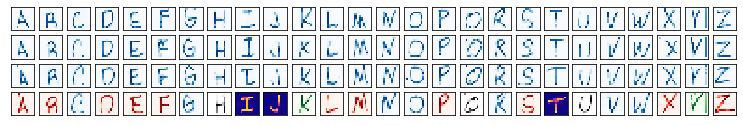

Response 2 : Correctly classified 12/26.
46.15384615384615% correct


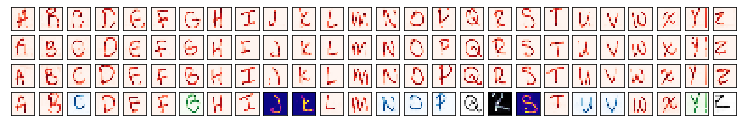

Response 3 : Correctly classified 4/26.
15.384615384615385% correct


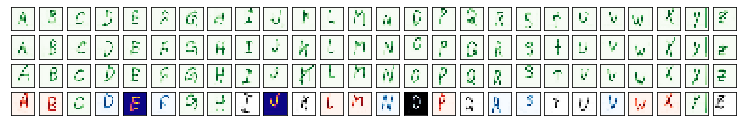

Response 4 : Correctly classified 7/26.
26.923076923076923% correct


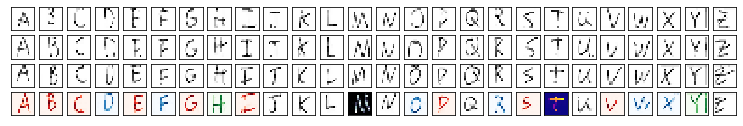

Response 5 : Correctly classified 5/26.
19.230769230769234% correct


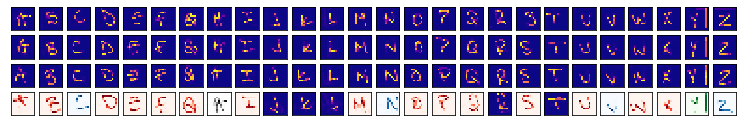

Response 6 : Correctly classified 6/26.
23.076923076923077% correct


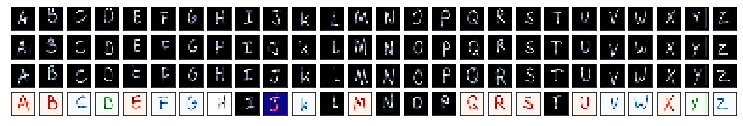

Total 26.282051282051285% correct.
Correctly predicted 41/156 correct.


In [9]:
# Creating and fitting the Naive Bayes classifiers
clfs = [naive_bayes.GaussianNB() for x in range(26)]
for i in range(26):
    clfs[i].fit(X_trains[i], y_trains[i])
    
# Using the visualization function to evaluate the NB
plot_classified_digits(clfs)

### Decision Tree
I will first start by finding the most accurate `max_depth`. To measure this, I will look at the average score for each max depth. To help mitigate the randomness associated with this process, I will measure these scores 10 different times, each with a unique random state. After this I will calculate the average to find the optimal `max_depth`

#### Optimization

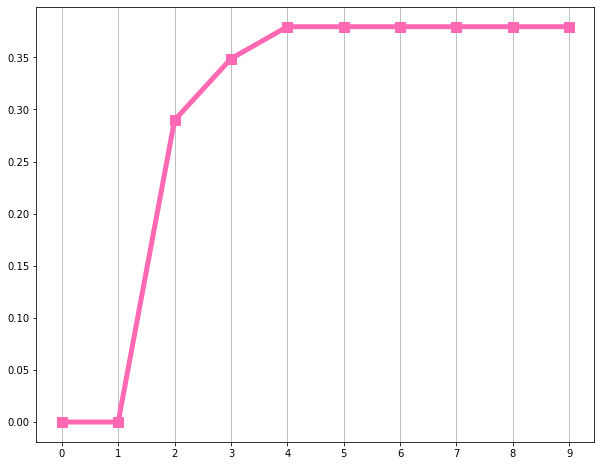

Average for max_depth = 0:  0.0
Average for max_depth = 1:  0.0
Average for max_depth = 2:  0.2897435897435899
Average for max_depth = 3:  0.3487179487179486
Average for max_depth = 4:  0.3794871794871796
Average for max_depth = 5:  0.3794871794871796
Average for max_depth = 6:  0.3794871794871796
Average for max_depth = 7:  0.3794871794871796
Average for max_depth = 8:  0.3794871794871796
Average for max_depth = 9:  0.3794871794871796


In [11]:
max_max_depth = 10
max_rand = 10
scores_DT = [0]*max_max_depth

depths = [x for x in range(2, max_max_depth)]

count = 0
# Creating and fitting decision trees for every random_state 1-10, and max_depth 2-10,
#  and keeping a running total of the average best max_depth.
for rand in range(max_rand):
    for depth in depths:
        clfs = [tree.DecisionTreeClassifier(max_depth=depth, random_state=rand) for x in range(26)]
        
        for i in range(26):
            count += 1
            clfs[i].fit(X_trains[i], y_trains[i])
            scores_DT[depth] += clfs[i].score(X_tests[i], y_tests[i])

# Formating the scores to contain the average, not the sum scores
scores_DT = [scores_DT[i]/(max_rand*26) for i in range(max_max_depth)]

# Plotting scores vs max_depth
plt.figure(figsize=(10,8))
plt.plot(scores_DT, color="hotpink", lw=5, marker="s", ms=10)
plt.xticks([x for x in range(max_max_depth)])
plt.grid(axis="x")
plt.show()

# Printing scores & max_depth
for i, score in enumerate(scores_DT):
    print(f"Average for max_depth = {i}: ", score)

Given the way the curve looks, it's pretty safe to say checking higher values for `max_depth` won't imprpove the score. Because every `max_depth >= 5` has the same average score, I will use 5 as the `max_depth`

#### Evaluation

Response 1 : Correctly classified 11/26.
42.30769230769231% correct


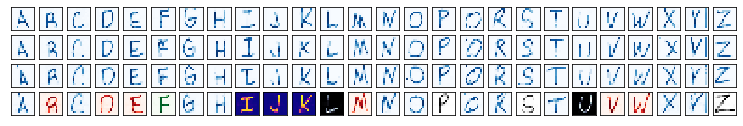

Response 2 : Correctly classified 9/26.
34.61538461538461% correct


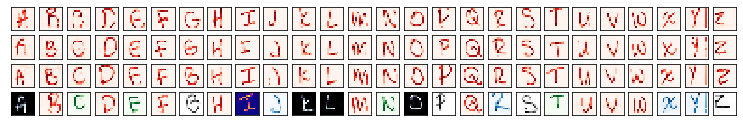

Response 3 : Correctly classified 9/26.
34.61538461538461% correct


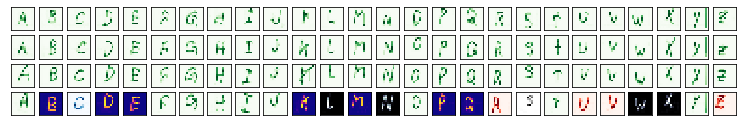

Response 4 : Correctly classified 10/26.
38.46153846153847% correct


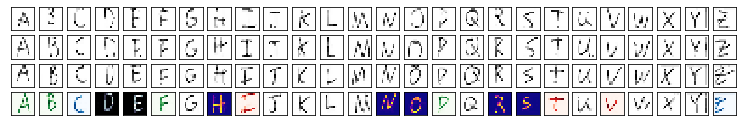

Response 5 : Correctly classified 11/26.
42.30769230769231% correct


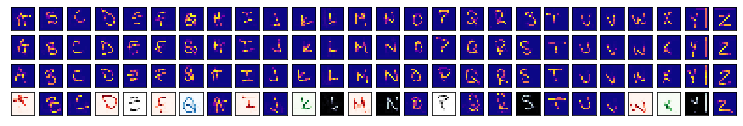

Response 6 : Correctly classified 11/26.
42.30769230769231% correct


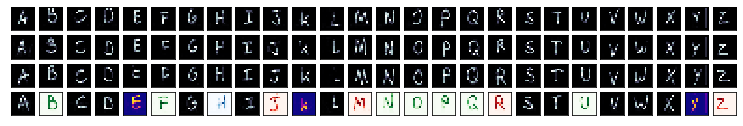

Total 39.1025641025641% correct.
Correctly predicted 61/156 correct.


In [12]:
# Making/fitting decision tree clasifiers with optimal max_depth values
clfs = [tree.DecisionTreeClassifier(max_depth=5, random_state=1) for x in range(26)]
for i in range(26):
    clfs[i].fit(X_trains[i], y_trains[i])
    
# Visualizing the decision tree results
plot_classified_digits(clfs)

### KNeighbors
Similar to the Decision Tree, I will start by finding the optimal parameters. This time that parameter is `n_neighbors`

#### Optimization

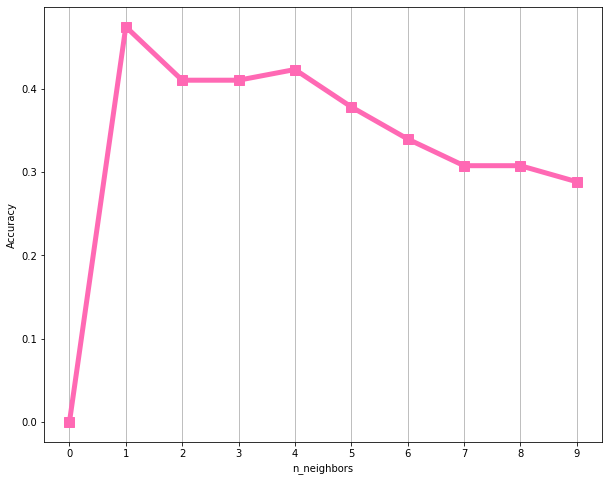

Average for n_neighbors = 0:  0.0
Average for n_neighbors = 1:  0.4743589743589744
Average for n_neighbors = 2:  0.4102564102564103
Average for n_neighbors = 3:  0.41025641025641024
Average for n_neighbors = 4:  0.423076923076923
Average for n_neighbors = 5:  0.37820512820512825
Average for n_neighbors = 6:  0.33974358974358976
Average for n_neighbors = 7:  0.3076923076923077
Average for n_neighbors = 8:  0.3076923076923077
Average for n_neighbors = 9:  0.28846153846153844


In [13]:
max_neighbors = 10
scores_KN = [0]*max_neighbors

# Getting scores for each n_neighbor value 1-10, and storing scores
for neighbor in range(1, max_neighbors):
    clfs = [neighbors.KNeighborsClassifier(n_neighbors=neighbor) for x in range(26)]
    for i in range(26):
        clfs[i].fit(X_trains[i], y_trains[i])
        scores_KN[neighbor] += clfs[i].score(X_tests[i], y_tests[i])

# Formatting scores
scores_KN = [scores_KN[i]/26 for i in range(max_neighbors)]
    
# Plotting scores
plt.figure(figsize=(10,8))
plt.plot(scores_KN, color="hotpink", lw=5, marker="s", ms=10)
plt.xticks([x for x in range(max_neighbors)])
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.grid(axis="x")
plt.show()

# Printing scores & max_depth
for i, score in enumerate(scores_KN):
    print(f"Average for n_neighbors = {i}: ", score)

Similar to last time, checking higher values for `n_neighbors` will . 

I will be using 1 for the vlaue of `n_neighbors`

#### Evaluation

Response 1 : Correctly classified 19/26.
73.07692307692307% correct


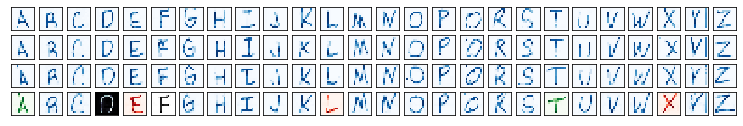

Response 2 : Correctly classified 10/26.
38.46153846153847% correct


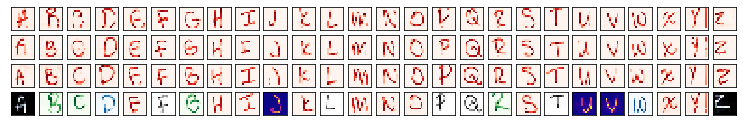

Response 3 : Correctly classified 11/26.
42.30769230769231% correct


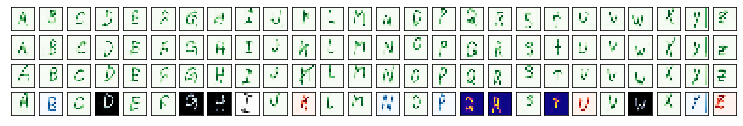

Response 4 : Correctly classified 8/26.
30.76923076923077% correct


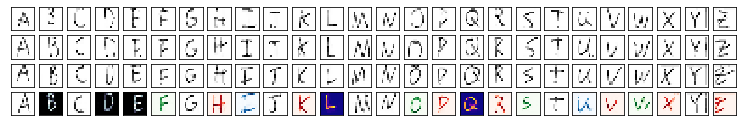

Response 5 : Correctly classified 14/26.
53.84615384615385% correct


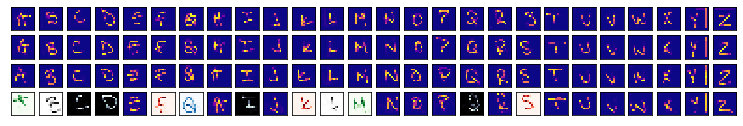

Response 6 : Correctly classified 12/26.
46.15384615384615% correct


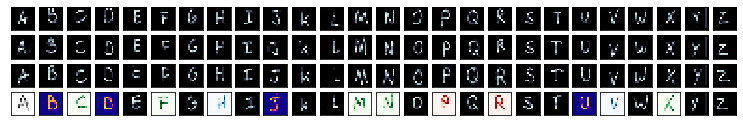

Total 47.43589743589743% correct.
Correctly predicted 74/156 correct.


In [14]:
# Creating and fitting classifiers with optimal value for n_neighbors
clfs = [neighbors.KNeighborsClassifier(n_neighbors=1) for x in range(26)]
for i in range(26):
    clfs[i].fit(X_trains[i], y_trains[i])

# Visualizing
plot_classified_digits(clfs)

## Conclusion & Possible Future Improvements
I was fairly impressed with the accuracy of the clasifiers. 47% is much better than I was anticipating. Overall, I would consider this experiment a success.

Even with this, There is still a couple improvements or interesting changes that could be made. The most obvious one would be the addition of more data. This would come in two forms, either more samples per person, or more people to give samples. I think both of these could have interesting impacts on the results. I think it would also be interesting to see what how smaller letter boxes would effect the results. The reason I say this is because the line width would effectivley be larger. Because there would be less white space, it might effect the classifiers' accuracy. More intersting changes could be made, but these would probably the most impactful.